# Data Science Project: Restaurant Recommendation System for Pune City:

1. Mohit Zanwar - 111903145
2. Rohaan Advani - 111903151
3. Shilpa Mohan - 111903155

## 1. IMPORT LIBRARIES, MODELS AND METRICS:

In [1]:
# Import Numpy and Pandas to work with Dataframes
import numpy as np
import pandas as pd
# Import math for calculations
import math
# Import seaborn for graphical data analysis
import seaborn as sns
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
# Import datetime for calc variable sb(snacks/beverages)
from datetime import datetime
# Import Scaler to Scale Data in order to build model
from sklearn.preprocessing import StandardScaler
# Import metrics to evaluate models
from sklearn import metrics
# Import train / test split
from sklearn.model_selection import train_test_split

# Models: Recommendation is a classification problem since either restaurants are recommended(1) or not(0)
# 1. KNN
from sklearn.neighbors import KNeighborsClassifier
# 2. Decision Tree
from sklearn import tree
# 3. Logistic Regression
from sklearn.linear_model import LogisticRegression
# 4. Random Forest
from sklearn.ensemble import RandomForestClassifier

## 2. RESTAURANT RECOMMENDATION FUNCTIONS & USER INPUT:

In [2]:
# Function to Drop Unnecessary Columns from restaurant data
def preprocess_restdata():
    df = pd.read_csv('New_rest_data.csv')
    df.drop(df.columns[0], axis = 1, inplace = True)
    # Drop all location encoded columns and use location distance table created instead
    df.drop(df.columns[10:35], axis = 1, inplace = True)
    # Drop unencoded columns and retain their encoded forms 
    df.drop(df.columns[7:9], axis = 1, inplace = True)
    df.drop(df.columns[10:12], axis = 1, inplace = True)
    return df

In [3]:
# Function to sort a nested list by the first value of every sublist
def Sort(sub_li):
        sub_li.sort(key = lambda x: x[1])
        return sub_li

In [4]:
# Take user input:
# 1. Age - determines sa(student area) is age between 10 and 25
age = int(input('Enter Age :'))
if (age>10 and age<25):
    sa = 1
else:
    sa = 0

# 2. Area of Residence - determines location and location based restaurant preferences
aor = input('Enter Area of Residence - Aundh, Baner, Bavdhan, Bhosari, Bibwewadi, Hadapsar, Hinjewadi, Kalyani Nagar, Kharadi, Kondhwa, Koregaon Park, Kothrud, Magarpatta, Narhe, Nigdi, PCMC, Pimple Saudagar, Pimpri Chinchwad, Shivaji Nagar, Sinhgad, Swargate, Viman Nagar, Vishrantwadi, Wagholi, Wakad, Warje :')

# 3. Occupation - determines job based restaurant preferences
occ = input('Enter Occupation :')

# 4. Cuisine Preferences (Enter Multiple Cusines seperated by comma(,))
cuisine = input('Enter Favourite Food Items / Cuisines :')

# 5. User's intrest in Fine Dining
fd = int(input('Do you prefer fine dine restaurants? (Enter 1 if yes 0 if no) :'))

# 6. User's intrest in Night Life
nl = int(input('Are you intrested in events, clubbing and partying? (Enter 1 if yes 0 if no) :'))

# 7. User's intrest in Food Type
jf = int(input('Are you concious about health, diet and weight? (Enter 1 if yes 0 if no) :'))

# 8. Take current time to determine whether it is time for lunch/dinner or snacks/beverages
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
ct = current_time.split(":")
if ((int(ct[0]) >= 12 and int(ct[0]) < 16) or (int(ct[0]) >= 19 and int(ct[0]) < 23)):
    sb = 0
else:
    sb = 1

Enter Age :24
Enter Area of Residence - Aundh, Baner, Bavdhan, Bhosari, Bibwewadi, Hadapsar, Hinjewadi, Kalyani Nagar, Kharadi, Kondhwa, Koregaon Park, Kothrud, Magarpatta, Narhe, Nigdi, PCMC, Pimple Saudagar, Pimpri Chinchwad, Shivaji Nagar, Sinhgad, Swargate, Viman Nagar, Vishrantwadi, Wagholi, Wakad, Warje :PCMC
Enter Occupation :Teacher
Enter Favourite Food Items / Cuisines :Pizzas
Do you prefer fine dine restaurants? (Enter 1 if yes 0 if no) :1
Are you intrested in events, clubbing and partying? (Enter 1 if yes 0 if no) :1
Are you concious about health, diet and weight? (Enter 1 if yes 0 if no) :0


In [5]:
# Function to calculate preference score based on fields of user input
def calc_pref(df):
    # Count Array - Keeps Count of common cuisines / food items between users prefernce and each restaurants cuisine
    cnt_arr = []
    # cui stores list of cuisine items user prefers
    cui = cuisine.split(",")
    for i in df.CuisineType:
        cnt = 0
        # cui2 stores list of cuisine items restaurant offers
        cui2 = i.split(",")
        # cnt stores count of common items between cui and cui2
        cnt =  len([i for i in cui2 if i in cui])
        cnt_arr.append(cnt)
    # Count Array is included in the preference score column
    df["Pref"] = cnt_arr

    for i in range(0, 7245):
        # Incremented Preference Score by 1 for restaurants having rating > 4.5 Stars
        if (df["Stars"][i] >= 4.5):
            df["Pref"][i] += 1
        # Decrement Preference Score by 1 score too cheap / expensive restaurants
        if (df["Pricefortwo"][i] >= 1000 or df["Pricefortwo"][i] <= 300):
            df["Pref"][i] -= 1
        # Increment Preference Score by 1 for each restaurants field matching with user preferences
        if (df["FineDine"][i] == fd):
            df["Pref"][i] += 1
        if (df["NightLife"][i] == nl):
            df["Pref"][i] += 1
        if (df["Junk Food"][i] == jf):
            df["Pref"][i] += 1
        if (df["Snacks/Beverages"][i] == sb):
            df["Pref"][i] += 1
        if (df["StudentArea"][i] == sa):
            df["Pref"][i] += 1

    return df

In [6]:
# Function to calculate location preference score based on users aor
def calc_loc_pref(df):
    distdf = pd.read_csv('distance.csv')
    distdf.drop(distdf.columns[0], axis = 1, inplace = True)

    # Store users X and Y coordinate as per aor
    for i in range(26):
        if distdf["Location"][i] == aor:
            loc_x = distdf["X"][i]
            loc_y = distdf["Y"][i]
    distdf["Z"] = 0

    # Calculate distance of each area from users area using euclidean distance
    for i in range(26):
        distdf["Z"][i] = math.sqrt(pow(loc_x - distdf["X"][i], 2) + pow(loc_y - distdf["Y"][i], 2))

    # Location Pref Order List -Store Location and respective Z scores of all restaurants
    loc_pref_order = []
    for i in range(26):
        temp = []
        temp.append(distdf["Location"][i])
        temp.append(distdf["Z"][i])
        loc_pref_order.append(temp)

    # Sort List by Z scores 
    loc_pref_order = Sort(loc_pref_order)

    # Set Location Pref Scores on Sorted Locations
    j = 26
    for i in loc_pref_order:
        i[1] = j
        j-=1

    # Add Location Pref Scores to dataframe
    df["LocPref"] = 0
    for i in range(7245):
        for k in loc_pref_order:
            if df["Location"][i] == k[0]:
                df["LocPref"][i] = k[1]

    return df

In [7]:
# Function to calculate job preference score based on users occ
def calc_job_pref(df):
    jobdf = pd.read_csv('job.csv')
    
    # Calculate Daily Salary and Estimated Meal Cost for all available professions
    jobdf["Daily Salary"] = 0
    jobdf["Estimated Meal Cost"] = 0
    for i in range(27):
        jobdf["Daily Salary"][i] = int(jobdf["MONTHLY SALARY"][i])/30
    for i in range(27):
        jobdf["Estimated Meal Cost"][i] = int(jobdf["Daily Salary"][i])/2

    # Determine estimated meal cost based on users profession
    emc = 0
    for i in range(27):
        if jobdf["JOB"][i] == occ:
            emc = jobdf["Estimated Meal Cost"][i]

    # Calculate differences between emc of user and emc of other professions
    jobdf["diff"] = 0
    for i in range(27):
        jobdf["diff"][i] = emc - jobdf["Estimated Meal Cost"][i]

    # Job Preference Order List Stores all Jobs' emc and diff scores
    job_pref_order = []
    for i in range(27):
        temp2 = []
        temp2.append(jobdf["Estimated Meal Cost"][i])
        temp2.append(jobdf["diff"][i])
        job_pref_order.append(temp2)

    # Sort List Based on diff scores
    job_pref_order = Sort(job_pref_order)

    # Set Job Preference for respective jobs
    l = 27
    for i in job_pref_order:
        i[1] = l
        l-=1

    # Add Jobs Prefernce Score column upon comparing job emc with Price for two of all restaurants
    df["JobPref"] = 0
    for i in range(7245):
         for k in job_pref_order:
            if k[0] >= df["Pricefortwo"][i]:
                 df["JobPref"][i] = k[1]

    return df

In [8]:
# Function to determine whether a particular restaurant is recomended to user on not
def rec(df, df3, userscore):
    df3.reset_index(inplace = True, drop = True)
    df["Rec"] = 0
    # Recommend all restaurants in users top 10 list by default
    for i in range(7245):
        for k in range(10):
            if df3["RestaurantName"][k] == df["RestaurantName"][i]:
                df["Rec"][i] = 1

    # For model building recommend restaurants based on high preference scores
    for i in range(7245):
        if df["Pref"][i] >= 4:
                df["Rec"][i] = 1
        if df["LocPref"][i] >= 23:
                df["Rec"][i] = 1
        if df["JobPref"][i] >= 15:
                df["Rec"][i] = 1
    
    # Save Topten list of user in order to add to user table   
    topten = []
    for i in range(10):
        topten.append(df3["RestaurantName"][i])
    
    # Compare userscore or current user with user scores of all past users
    userdf = pd.read_csv('user.csv')
    userdf2 = userdf
    userdf2.drop(userdf.columns[0], axis = 1, inplace = True)
    # Calculate userscore difference power is 6 to increase variance
    userdf2["us_diff"] = 0
    for i in userdf.index:
        userdf2["us_diff"][i] = pow(userdf2["Userscore"][i],6) - pow(userscore,6)
    # Sort and choose the top 5 users whose user score is closest to current user
    userdf2 = userdf2.sort_values(by = ['us_diff'])
    userdf3 = userdf2.head(5)
    userdf3.reset_index(inplace = True, drop = True)
    # Use TopTen restaurants recommended to other users with similar user score and reccommend same restaurants to Current User
    for i in range(7245):
        for k in range(5):
            if df["RestaurantName"][i] in userdf3["RestList"][k]:
                df["Rec"][i] = 1

    return df, topten

In [9]:
# Function to calculate avg preference in order to determine userscore
def calc_avg_pref(df, userscore):
    df["AvgPref"] = 0
    for i in range(7245):
        df["AvgPref"][i] = (df["Pref"][i] + df["LocPref"][i] + df["JobPref"][i])/3
    for i in range(7245):
        userscore += df["AvgPref"][i]
    # userscore is the avg of all the avg preference scores
    userscore /= 7245
    return df, userscore

In [10]:
# Function to add userscore and topten rest recc to current user to user table
def add_user_det(userscore, topten):
    userdf = pd.read_csv('user.csv')
    userdf.drop(userdf.columns[0], axis = 1, inplace = True)
    new = [userscore,topten]
    userdf = userdf.append(pd.Series(new, index=userdf.columns[:len(new)]), ignore_index=True)
    #userdf.loc[len(userdf.index)] = [userscore,topten]
    userdf.to_csv('user.csv')

In [11]:
def add_rec_restdata(df):
    df_rec = df[df['Rec'] == 1]
    df_rec2 = df_rec["RestaurantName"]
    df_rec2.reset_index(inplace = True, drop = True)
    df_rec2.to_csv('all_rec.csv')
    return df_rec2

## 3. RECOMMEND TOP 10 RESTAURANTS TO USERS:

In [12]:
userscore = 0
df = preprocess_restdata()
df = calc_pref(df)
df = calc_loc_pref(df)
df = calc_job_pref(df)
df, userscore = calc_avg_pref(df, userscore)
# Sort Dataframe in Desc order of Preference Scores (Higher the preference the more recommended the restaurant is)
df2 = df.sort_values(by = ['LocPref', 'Pref', 'JobPref'], ascending = [False, False, False])
# Find Top 10 recommended restaurants for the user
df3 = df2.head(10)
df, topten = rec(df, df3, userscore)
dfr = add_rec_restdata(df)
add_user_det(userscore,topten)
df4 = df3["RestaurantName"]
# Given Below are the Top 10 recommended restaurants for the user
df4.to_csv('top10_rec.csv')
df3

,RestaurantName,CuisineType,Stars,Pricefortwo,Location,FineDine,NightLife,StudentArea,Junk Food,Snacks/Beverages,Pref,LocPref,JobPref,AvgPref
0,Metro Nine Restro Bar,"North Indian, Mughlai, Malwani, Continental, C...",4.1,575,PCMC,1,0,1,0,0,4,26,15,15
1,Swadesh,"Chinese, North Indian",4.5,575,PCMC,0,0,1,0,0,4,26,15,15
2,Barbeque Nation,"North Indian, Mughlai, Seafood, Biryani, Desse...",4.7,575,PCMC,0,0,1,0,0,4,26,15,15
3,Little Italy,"Pizzas, Salads, Combo, Italian, Mexican, Desse...",4.2,575,PCMC,1,0,1,1,0,4,26,15,15
4,Doubletree by Hilton,"American, Asian, Indian",4.4,575,PCMC,1,0,1,0,0,4,26,15,15
5,TAKHT - The Rooftop Lounge,"North Indian, Chinese",4.8,575,PCMC,0,0,1,0,0,4,26,15,15
6,Holiday Inn Express,"Indian, Chinese",4.8,575,PCMC,0,0,1,0,0,4,26,15,15
7,THE TASTY WOK,"Indian, Chinese",4.6,500,PCMC,0,0,1,0,0,4,26,13,14
8,Sheetal Refreshment,"North Indian, Chinese, South Indian, Beverages",4.6,450,PCMC,0,0,1,0,0,4,26,13,14
9,The royal champaran meat house,"Thalis, Indian",4.6,500,PCMC,0,0,1,0,0,4,26,13,14


## 4. RECOMMENDATION ANALYSIS AND PREPATION FOR MODELLING:

In [13]:
# Data Available for modelling
df

,RestaurantName,CuisineType,Stars,Pricefortwo,Location,FineDine,NightLife,StudentArea,Junk Food,Snacks/Beverages,Pref,LocPref,JobPref,AvgPref,Rec
0,Paper Lantern,Asian,4.3,400,Aundh,0,0,0,0,0,2,21,12,11,0
1,Platfoorm 9 3/4,"Pizzas, Pastas, Italian, Fast Food, Snacks, Be...",4.0,400,Aundh,0,0,0,1,0,2,21,12,11,0
2,Creamy Culture,Bakery,4.8,250,Aundh,0,0,0,0,0,2,21,2,8,0
3,GetaWhey,"Desserts, Ice Cream, Healthy Food",4.5,200,Aundh,0,0,0,0,0,2,21,2,8,0
4,VASTAD BHURJIWALE,Continental,4.7,200,Aundh,0,0,0,0,0,2,21,2,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7240,McDonald's,"American, Fast Food",4.3,400,Warje,0,0,0,1,0,1,9,12,7,0
7241,Corner Sweets,"Desserts, Sweets",4.2,200,Warje,0,0,0,0,0,1,9,2,4,0
7242,BOX8 - Desi Meals,"North Indian, Biryani, Fast Food, Desserts, Combo",4.4,250,Warje,0,0,0,1,0,0,9,2,3,0
7243,LeanCrust Pizza - ThinCrust Experts,"Pizzas, Italian",4.3,350,Warje,0,0,0,1,0,2,9,12,7,0


In [14]:
result = df.groupby(['Location','Stars'],axis=0)
result.size()

Location  Stars
Aundh     3.5       2
          3.6       9
          3.7      13
          3.8      11
          3.9       8
                   ..
Warje     4.4      10
          4.5       9
          4.6       4
          4.7       5
          4.8       1
Length: 375, dtype: int64

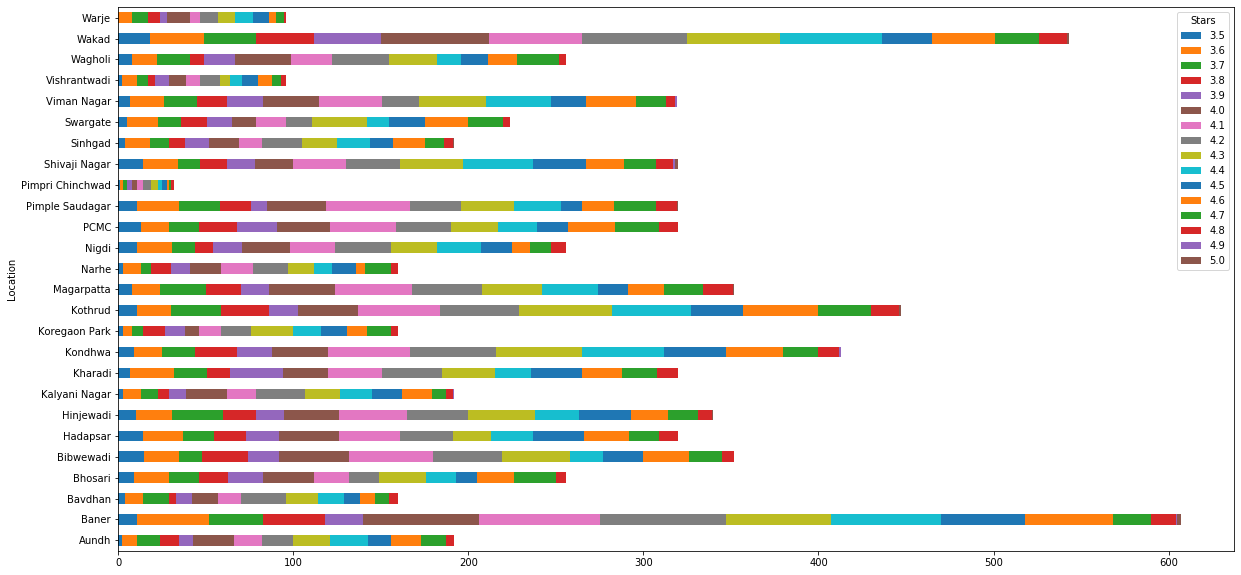

In [15]:
pd.crosstab(df['Location'],df['Stars']).plot(kind = 'barh', stacked = True , figsize = (20,10))

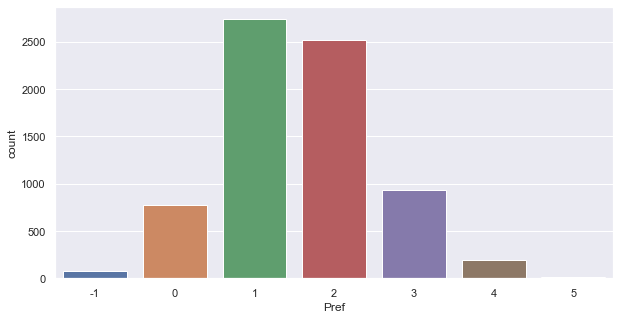

In [16]:
# Data Analysis of Pref
sns.set(rc = {'figure.figsize':(10,5)})
chart = sns.countplot(x='Pref', data=df)

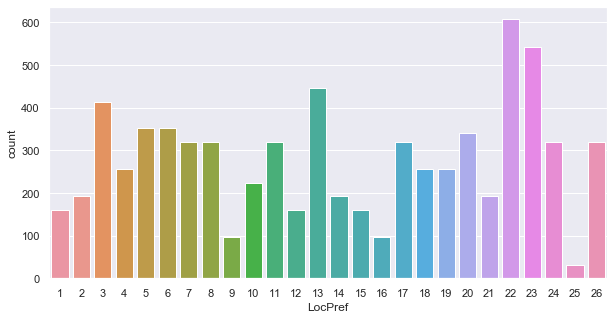

In [17]:
# Data Analysis of LocPref
sns.set(rc = {'figure.figsize':(10,5)})
chart = sns.countplot(x='LocPref', data=df)

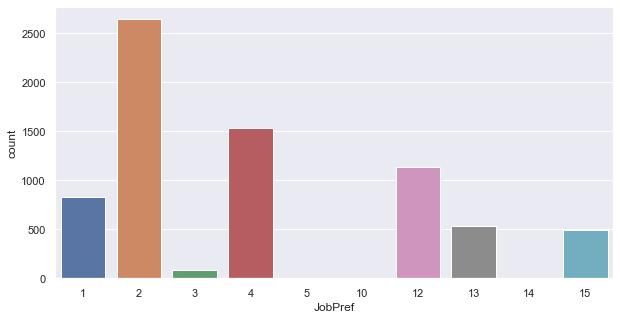

In [18]:
# Data Analysis of JobPref
sns.set(rc = {'figure.figsize':(10,5)})
chart = sns.countplot(x='JobPref', data=df)

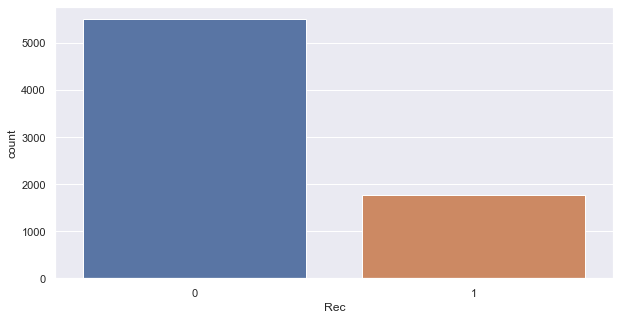

In [19]:
# Data Analysis of Rec
sns.set(rc = {'figure.figsize':(10,5)})
chart = sns.countplot(x='Rec', data=df)

In [20]:
# Pref, LocPref, JobPref and Rec are columns built on basis of all the other columns thus retain these for model and drop others
df.drop(df.columns[0:10], axis = 1, inplace = True)
df.drop(df.columns[3], axis = 1, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7245 entries, 0 to 7244
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   Pref     7245 non-null   int64
 1   LocPref  7245 non-null   int64
 2   JobPref  7245 non-null   int64
 3   Rec      7245 non-null   int64
dtypes: int64(4)
memory usage: 226.5 KB


In [21]:
# Function to treat outlier values in the 3 preference columns
def treat_outliers(df):
    IQR_pref = df['Pref'].quantile(0.75)-df['Pref'].quantile(0.25)
    Upper_OutlierLimit_pref = df['Pref'].quantile(0.75) + 1.5*IQR_pref
    Lower_OutlierLimit_pref = df['Pref'].quantile(0.25) - 1.5*IQR_pref
    OutlierValues_pref = df[(df['Pref']>=Upper_OutlierLimit_pref) | (df['Pref']<=Lower_OutlierLimit_pref)]

    for i in range(0,7245):
        if df['Pref'][i] >= Upper_OutlierLimit_pref:
            df['Pref'][i] = Upper_OutlierLimit_pref
        elif df['Pref'][i] <= Lower_OutlierLimit_pref:
            df['Pref'][i] = Lower_OutlierLimit_pref
        else:     
            continue

    IQR_locpref = df['LocPref'].quantile(0.75)-df['LocPref'].quantile(0.25)
    Upper_OutlierLimit_locpref = df['LocPref'].quantile(0.75) + 1.5*IQR_locpref
    Lower_OutlierLimit_locpref = df['LocPref'].quantile(0.25) - 1.5*IQR_locpref
    OutlierValues_locpref = df[(df['LocPref']>=Upper_OutlierLimit_locpref) | (df['LocPref']<=Lower_OutlierLimit_locpref)]

    for i in range(0,7245):
        if df['LocPref'][i] >= Upper_OutlierLimit_locpref:
            df['LocPref'][i] = Upper_OutlierLimit_locpref
        elif df['LocPref'][i] <= Lower_OutlierLimit_locpref:
            df['LocPref'][i] = Lower_OutlierLimit_locpref
        else:     
            continue

    IQR_jobpref = df['JobPref'].quantile(0.75)-df['JobPref'].quantile(0.25)
    Upper_OutlierLimit_jobpref = df['JobPref'].quantile(0.75) + 1.5*IQR_jobpref
    Lower_OutlierLimit_jobpref = df['JobPref'].quantile(0.25) - 1.5*IQR_jobpref
    OutlierValues_jobpref = df[(df['JobPref']>=Upper_OutlierLimit_jobpref) | (df['JobPref']<=Lower_OutlierLimit_jobpref)]

    for i in range(0,7245):
        if df['JobPref'][i] >= Upper_OutlierLimit_jobpref:
            df['JobPref'][i] = Upper_OutlierLimit_jobpref
        elif df['JobPref'][i] <= Lower_OutlierLimit_jobpref:
            df['JobPref'][i] = Lower_OutlierLimit_jobpref
        else:     
            continue
    
    return df

In [22]:
# Function to Scale the Dataframe
def input_scaler(df):
    scaler = StandardScaler()
    scale_cols = df[['Pref', 'LocPref', 'JobPref']]
    df_scaled = scaler.fit_transform(scale_cols.to_numpy())
    df_scaled = pd.DataFrame(df_scaled, columns=['Pref', 'LocPref', 'JobPref'])
    df_scaled.rename(columns = {'Pref':'P'}, inplace = True)
    df_scaled.rename(columns = {'LocPref':'LP'}, inplace = True)
    df_scaled.rename(columns = {'JobPref':'JP'}, inplace = True)
    df4 = pd.concat([df, df_scaled], axis=1)
    df4.drop(df.columns[0:3], axis = 1, inplace = True)
    return df4

In [23]:
df = treat_outliers(df)
df = input_scaler(df)
# Below is the Dataframe ready to be modeled
df

,Rec,P,LP,JP
0,0,0.510943,0.931572,1.303616
1,0,0.510943,0.931572,1.303616
2,0,0.510943,0.931572,-0.728288
3,0,0.510943,0.931572,-0.728288
4,0,0.510943,0.931572,-0.728288
...,...,...,...,...
7240,0,-0.608096,-0.646859,1.303616
7241,0,-0.608096,-0.646859,-0.728288
7242,0,-1.727135,-0.646859,-0.728288
7243,0,0.510943,-0.646859,1.303616


## 5. X/Y TRAIN/TEST SPLIT, MODEL BUILDING, EVALUATION AND COMPARISON:

In [24]:
# X / Y Split
X = df.iloc[:, 1:4].values 
Y = df.iloc[:, 0].values

# Train / Test Split
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.25, random_state=0)

In [25]:
# Function to Evaluate Model
def evaluate_model(model, test_X, test_Y):
    # Predict Test Data
    pred_Y = model.predict(test_X)
    # Calculate Metrics
    acc = metrics.accuracy_score(test_Y, pred_Y)
    prec = metrics.precision_score(test_Y, pred_Y)
    rec = metrics.recall_score(test_Y, pred_Y)
    f1 = metrics.f1_score(test_Y, pred_Y)
    cm = metrics.confusion_matrix(test_Y, pred_Y)
    # Return Metrics
    return {'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1, 'cm': cm}

In [26]:
# Build Model
knn = KNeighborsClassifier(n_neighbors = 5)
# Fit Model
knn.fit(train_X, train_Y)
# Evaluate Model
knn_eval = evaluate_model(knn, test_X, test_Y)
# Print results
print('Accuracy:', knn_eval['acc'])
print('Precision:', knn_eval['prec'])
print('Recall:', knn_eval['rec'])
print('F1 Score:', knn_eval['f1'])
print('Confusion Matrix:\n', knn_eval['cm'])

Accuracy: 0.9850993377483444
Precision: 0.9926108374384236
Recall: 0.9437939110070258
F1 Score: 0.9675870348139256
Confusion Matrix:
 [[1382    3]
 [  24  403]]


In [27]:
# Build Model 
clf = tree.DecisionTreeClassifier(random_state=0)
# Fit Model
clf.fit(train_X, train_Y)
# Evaluate Model
clf_eval = evaluate_model(clf, test_X, test_Y)
# Print results
print('Accuracy:', clf_eval['acc'])
print('Precision:', clf_eval['prec'])
print('Recall:', clf_eval['rec'])
print('F1 Score:', clf_eval['f1'])
print('Confusion Matrix:\n', clf_eval['cm'])

Accuracy: 0.9873068432671082
Precision: 1.0
Recall: 0.9461358313817331
F1 Score: 0.9723225030084236
Confusion Matrix:
 [[1385    0]
 [  23  404]]


In [28]:
# Build Model
log = LogisticRegression()
# Fit Model
log.fit(train_X,train_Y)
# Evaluate Model
log_eval = evaluate_model(log, test_X, test_Y)
# Print results
print('Accuracy:', log_eval['acc'])
print('Precision:', log_eval['prec'])
print('Recall:', log_eval['rec'])
print('F1 Score:', log_eval['f1'])
print('Confusion Matrix:\n', log_eval['cm'])

Accuracy: 0.8509933774834437
Precision: 0.7082228116710876
Recall: 0.6252927400468384
F1 Score: 0.664179104477612
Confusion Matrix:
 [[1275  110]
 [ 160  267]]


In [29]:
## Build Model
forest = RandomForestClassifier(random_state = 0)
# Fit Model
forest.fit(train_X, train_Y)
# Evaluate Model
rf_eval = evaluate_model(forest, test_X, test_Y)
# Print results
print('Accuracy:', rf_eval['acc'])
print('Precision:', rf_eval['prec'])
print('Recall:', rf_eval['rec'])
print('F1 Score:', rf_eval['f1'])
print('Confusion Matrix:\n', rf_eval['cm'])

Accuracy: 0.9873068432671082
Precision: 1.0
Recall: 0.9461358313817331
F1 Score: 0.9723225030084236
Confusion Matrix:
 [[1385    0]
 [  23  404]]
